In [1]:
# Init
import glob
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# For loading data
import concurrent.futures
import gc
import json
import random

# Plotting imports
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def returnGen(lst):
    return lst[3000]


def returnMax(series):
    return max(series)


def returnList(HGTGen, lst):
    return lst[HGTGen]


def colorRanges(i):
    if i == 0:
        return "0"
    elif i > 0 and i <= 50:
        return "1-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


def zeroDivision(n, d):
    return n / d if d else maxVal


def dfWrangler(dataFrame):
    # Perform some data wrangling
    dataFrame[["TranspositionRate_1", "TranspositionRate_2"]] = pd.DataFrame(
        dataFrame.TRate.tolist(), index=dataFrame.index
    )
    dataFrame[["TE_1_CN", "TE_2_CN"]] = dataFrame["TEfamilyCN"].apply(pd.Series)
    dataFrame[["TE_1_RG", "TE_2_RG"]] = dataFrame["TEfamilyRg"].apply(pd.Series)
    dataFrame[["TE_1_pi", "TE_2_pi"]] = dataFrame["TEpi"].apply(pd.Series)

    # Add column for the last acn (average copy number) for each transposon family
    dataFrame["TE_1_ACN"] = dataFrame["TE_1_CN"].apply(lambda x: returnLast(x))
    dataFrame["TE_2_ACN"] = dataFrame["TE_2_CN"].apply(lambda x: returnLast(x))

    # Add column for copies not present in clusters
    dataFrame["TE_1_NCN"] = dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"]
    dataFrame["TE_2_NCN"] = dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"]
    dataFrame["TE_1_NCN_l"] = np.log(dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"])
    dataFrame["TE_2_NCN_l"] = np.log(dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"])

    # Add column for nth generation copy number
    dataFrame["TE_1_ACN_N"] = dataFrame["TE_1_CN"].apply(lambda x: returnGen(x))
    dataFrame["TE_2_ACN_N"] = dataFrame["TE_2_CN"].apply(lambda x: returnGen(x))

    # Get ranges for adding colors later
    dataFrame["TE_1_NCN_R"] = dataFrame["TE_1_NCN"].apply(lambda x: colorRanges(x))
    dataFrame["TE_2_NCN_R"] = dataFrame["TE_2_NCN"].apply(lambda x: colorRanges(x))

    # Add column for copy number ratio
    dataFrame["(α/β) copy number"] = dataFrame["TE_1_NCN"] / dataFrame["TE_2_NCN"]
    dataFrame["log(α/β) copy number"] = np.log(dataFrame["(α/β) copy number"])

    # Add column for max alpha and beta
    dataFrame["Max α"] = dataFrame["TE_1_CN"].apply(lambda x: returnMax(x))
    dataFrame["Max β"] = dataFrame["TE_2_CN"].apply(lambda x: returnMax(x))
    # dataFrame["Max α/β"] = np.log(dataFrame["Max α"] / dataFrame["Max β"])
    dataFrame["Max α/β"] = dataFrame["Max α"] / dataFrame["Max β"]

    return dataFrame


def dfReader(resultDir, suffix):
    # Read the json files into pandas dataframe
    SimulationRecords = []
    for filename in glob.glob(os.path.join(resultDir, suffix)):
        with open(filename, "r") as file:
            SimulationRecords.append(json.load(file))

    SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

    # Create a copy for inplace handling
    resultDataframe = SimulationResultsDataFrame.copy(deep=True)
    resultDataframe = dfWrangler(resultDataframe)
    return resultDataframe


# Since pickle format is not working as intended.
# Insert angry thoughts abouts pickle format here
# A function to open pickle files and convert into json
def pickleToJson(resultDir):
    for file in glob.glob(os.path.join(resultDir, "*.pickle")):
        # Check if json conversion already exists
        if os.path.isfile(file + ".json"):
            continue
        with open(file, "rb") as f:
            gc.disable()
            data = pickle.load(f)
            del data["TEset"]
            del data["NTE"]
            del data["NTI"]
            del data["AvgFit"]
            del data["Freq"]
            gc.enable()
            with open(file + ".json", "w") as fp:
                json.dump(data, fp)
    return 0


def TECNplot(df, ax, legend=True):
    resultDFT1 = pd.DataFrame(data=np.array(df["TE_1_CN"].tolist()))
    resultDFT1exp = list(resultDFT1.mean())
    resultDFT1mdn = list(resultDFT1.median())
    resultDFT1std = list(resultDFT1.std())

    resultDFT2 = pd.DataFrame(data=np.array(df["TE_2_CN"].tolist()))
    resultDFT2exp = list(resultDFT2.mean())
    resultDFT2mdn = list(resultDFT2.median())
    resultDFT2std = list(resultDFT2.std())

    # Meld for long form
    nameColumn = ["TE α"] * len(resultDFT1exp) + ["TE β"] * len(resultDFT2exp)
    exp = resultDFT1exp + resultDFT2exp
    mdn = resultDFT1mdn + resultDFT2mdn
    std = resultDFT1std + resultDFT2std
    generation = list(range(len(resultDFT1exp))) + list(range(len(resultDFT2exp)))
    plotDF = pd.DataFrame(
        {
            "TE": nameColumn,
            "Mean": exp,
            "Median": mdn,
            "std": std,
            "Generation": generation,
        }
    )
    plotDF["Mean"].replace(0, np.nan, inplace=True)
    sns.lineplot(
        data=plotDF,
        x="Generation",
        y="Mean",
        style="TE",
        hue="TE",
        ax=ax,
        legend=legend,
    )
    sns.scatterplot(
        x="Generation",
        y="Mean",
        ax=ax,
        style="TE",
        hue="TE",
        data=plotDF.loc[np.random.choice(plotDF.index, 100, replace=False)],
        legend=False,
        style_order=["TE α", "TE β"],
        hue_order=["TE α", "TE β"],
    )

In [3]:
# Path to results
resultDir = "./Results/"

# Convert them to json
returnValue = pickleToJson(resultDir)

In [4]:
# Read the results and get the four corners
resultDataframe = dfReader(resultDir, "*.pickle.json")
result_E0_G0 = resultDataframe[
    (resultDataframe["ETA"] == 0) & (resultDataframe["HGTGen"] == 0)
]
result_E0_G1000 = resultDataframe[
    (resultDataframe["ETA"] == 0) & (resultDataframe["HGTGen"] == 1000)
]
result_E1_G0 = resultDataframe[
    (resultDataframe["ETA"] == 1) & (resultDataframe["HGTGen"] == 0)
]
result_E1_G1000 = resultDataframe[
    (resultDataframe["ETA"] == 1) & (resultDataframe["HGTGen"] == 1000)
]
result_all = resultDataframe[
    (resultDataframe["ETA"] != 0)
    & (resultDataframe["ETA"] != 1)
    & (resultDataframe["HGTGen"] != 0)
    & (resultDataframe["HGTGen"] != 1000)
]

/home/siddharth/mambaforge/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


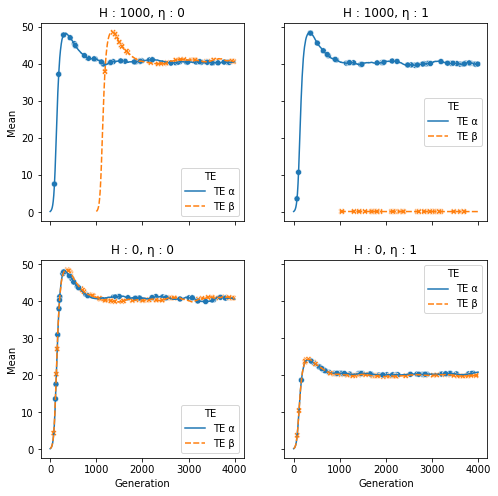

In [5]:
# Create a multipanel figure
# sns.set_context("talk")
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
(ax1, ax2), (ax3, ax4) = axs
TECNplot(result_E0_G1000, ax1)
ax1.title.set_text("H : 1000, η : 0")
TECNplot(result_E1_G1000, ax2)
ax2.title.set_text("H : 1000, η : 1")
TECNplot(result_E0_G0, ax3)
ax3.title.set_text("H : 0, η : 0")
TECNplot(result_E1_G0, ax4)
ax4.title.set_text("H : 0, η : 1")

Text(0, 0.5, 'H')

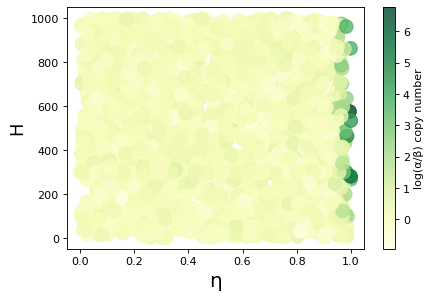

In [6]:
cmap = sns.color_palette("YlGn", as_cmap=True)

f, ax = plt.subplots(figsize=(6, 4), dpi=80)
points = ax.scatter(
    result_all["ETA"],
    result_all["HGTGen"],
    c=result_all["log(α/β) copy number"],
    s=150,
    cmap=cmap,
    alpha=0.8,
)
f.colorbar(points).set_label("log(α/β) copy number")
ax.set_xlabel("η", fontsize=18)
ax.set_ylabel("H", fontsize=16)

In [7]:
# Filter test generation 300
result_all = result_all[result_all["HGTGen"]!=300]

/tmp/ipykernel_76170/144223164.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(points, ax=ax_main, format=ticker.ScalarFormatter(useMathText=True), ticks=[1,2,5,10,20], label="Max α/β")


Text(0, 0.5, 'Introduction of TE β ($H$)')

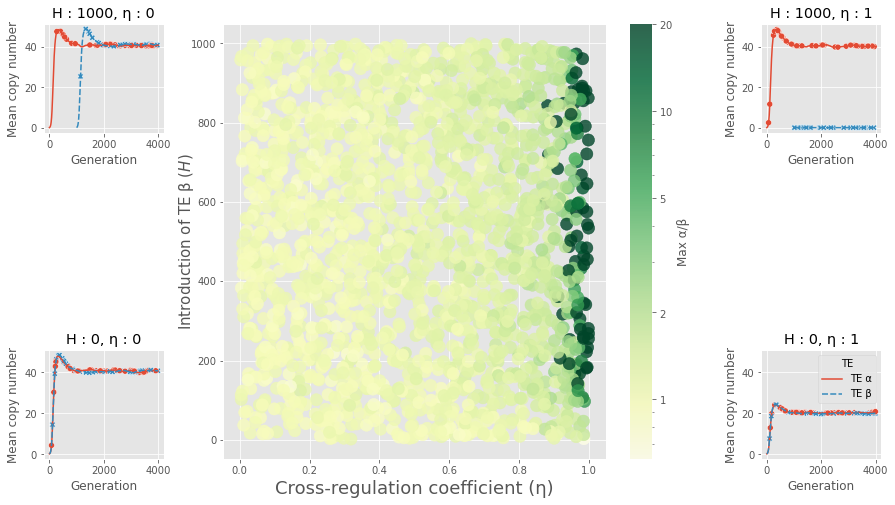

In [8]:
# A gridspec based approach for plotting
style.use("ggplot")
cmap = sns.color_palette("YlGn", as_cmap=True)

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace=0.5, hspace=0.5,)
# plt.subplots_adjust(left=0.50, bottom=0.08, right=0.85, top=0.92, wspace=0.2, hspace=0.08)

# Assign the grids
ax_main = plt.subplot(gs[0:3, 1:4])
ax_E0_G0 = plt.subplot(gs[2, 0])
ax_E1_G0 = plt.subplot(gs[2, 4])
ax_E0_G1000 = plt.subplot(gs[0, 0])
ax_E1_G1000 = plt.subplot(gs[0, 4])

# Plot the corners
TECNplot(result_E0_G1000, ax_E0_G1000, legend=False)
ax_E0_G1000.title.set_text("H : 1000, η : 0")
ax_E0_G1000.set_ylabel("Mean copy number")

TECNplot(result_E1_G1000, ax_E1_G1000, legend=False)
ax_E1_G1000.title.set_text("H : 1000, η : 1")
ax_E1_G1000.set_ylabel("Mean copy number")

TECNplot(result_E0_G0, ax_E0_G0, legend=False)
ax_E0_G0.title.set_text("H : 0, η : 0")
ax_E0_G0.set_ylabel("Mean copy number")

TECNplot(result_E1_G0, ax_E1_G0, legend=True)
ax_E1_G0.title.set_text("H : 0, η : 1")
ax_E1_G0.set_ylabel("Mean copy number")

# Share the Y axis
ax_E0_G1000.sharey(ax_E1_G1000)
ax_E0_G0.sharey(ax_E1_G0)

# Plot the main figure
points = ax_main.scatter(
    result_all["ETA"],
    result_all["HGTGen"],
    c=result_all["Max α/β"],
    s=150,
    cmap=cmap,
    alpha=0.8,
    norm=colors.LogNorm(vmin=result_all["Max α/β"].min(), vmax=20, clip=True),
)
# For changing to normal notation
colorbar = fig.colorbar(points, ax=ax_main, format=ticker.ScalarFormatter(useMathText=True), ticks=[1,2,5,10,20], label="Max α/β")
colorbar.outline.set_visible(False)


ax_main.set_xlabel("Cross-regulation coefficient (η)", fontsize=18)
ax_main.set_ylabel("Introduction of TE β ($H$)", fontsize=15, labelpad=-5)
# ax_main.set_title("s:0.005, N:2000, μ:0.2, T:1000, ", fontsize=16)


In [9]:
# Save the figure
fig.savefig("Figure1.pdf", bbox_inches='tight') 

In [10]:
# Save the figure using latex backend
fig.savefig("Figure1.pgf", bbox_inches='tight', format='pgf') 

/home/siddharth/mambaforge-pypy3/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


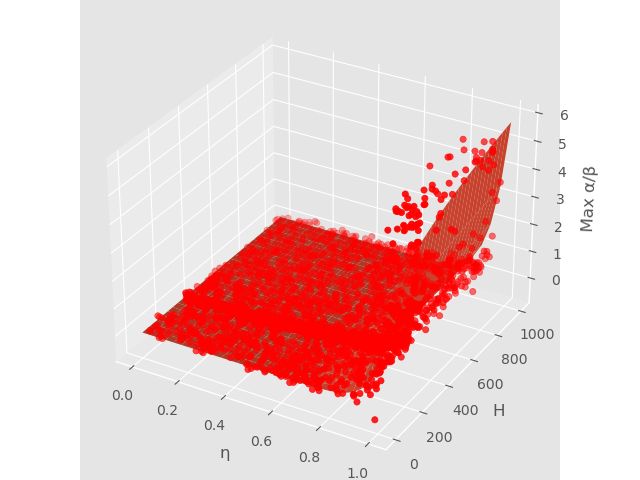

In [12]:
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# test function
def function(data, a, b, c):
    x = data[0]
    y = data[1]
    return a * (x**b) * (y**c)

# convert data into proper format
x_data = result_all["ETA"]
y_data = result_all["HGTGen"]
z_data = result_all["Max α/β"]

# get fit parameters from scipy curve fit
parameters, covariance = curve_fit(function, [x_data, y_data], z_data)

# create surface function model
# setup data points for calculating surface model
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
# create coordinate arrays for vectorized evaluations
X, Y = np.meshgrid(model_x_data, model_y_data)
# calculate Z coordinate array
Z = function(np.array([X, Y]), *parameters)

# setup figure object
fig = plt.figure()
# setup 3d object
ax = Axes3D(fig)
# plot surface
ax.plot_surface(X, Y, Z)
# plot input data
ax.scatter(x_data, y_data, z_data, color="red")
# set plot descriptions
ax.set_xlabel('η')
ax.set_ylabel('H')
ax.set_zlabel('Max α/β')

plt.show()

/home/siddharth/mambaforge-pypy3/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


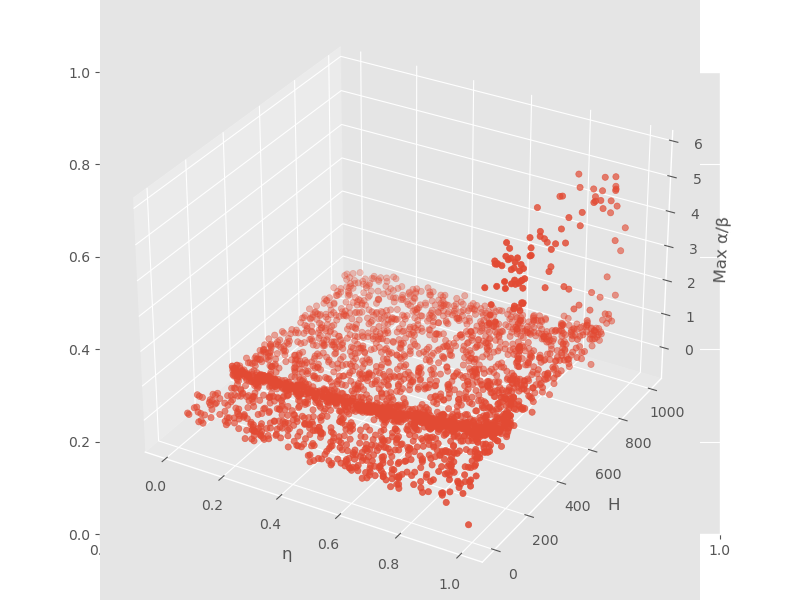

/home/siddharth/mambaforge-pypy3/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


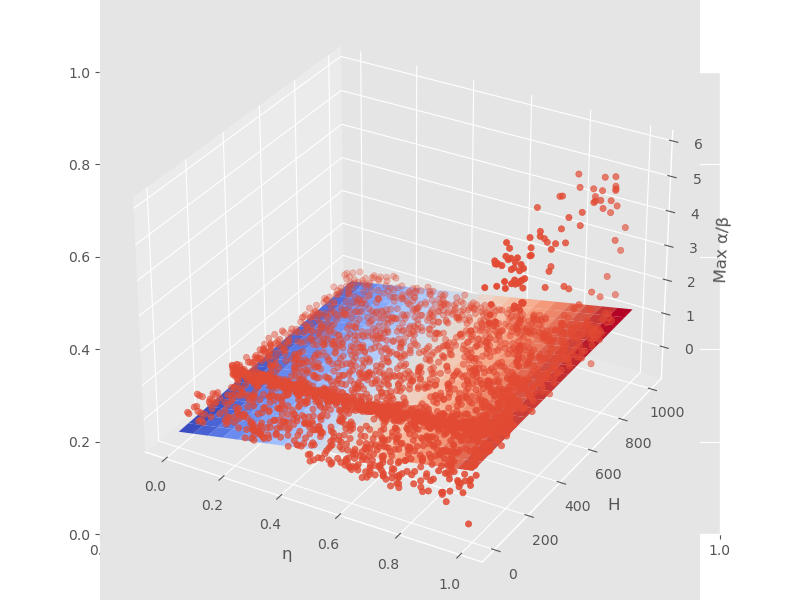

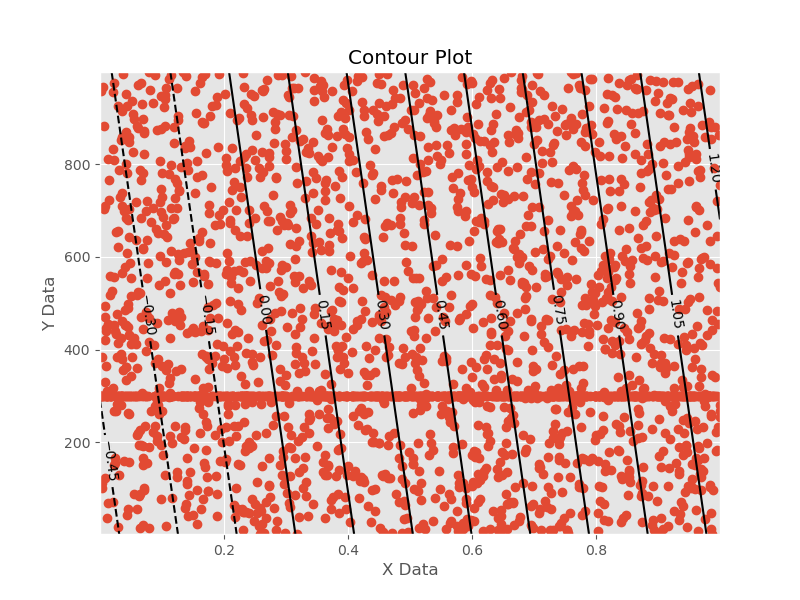

fitted prameters [ 1.58538721  0.00016985 -0.50018742]
RMSE: 0.7933571119137633
R-squared: 0.25073865941220286


In [11]:
%matplotlib widget
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt

graphWidth = 800 # units are pixels
graphHeight = 600 # units are pixels

# 3D contour plot lines
numberOfContourLines = 16


def SurfacePlot(func, data, fittedParameters):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)

    matplotlib.pyplot.grid(True)
    axes = Axes3D(f)

    x_data = data[0]
    y_data = data[1]
    z_data = data[2]

    xModel = numpy.linspace(min(x_data), max(x_data), 20)
    yModel = numpy.linspace(min(y_data), max(y_data), 20)
    X, Y = numpy.meshgrid(xModel, yModel)

    Z = func(numpy.array([X, Y]), *fittedParameters)

    axes.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=1, antialiased=True)

    axes.scatter(x_data, y_data, z_data) # show data along with plotted surface

    axes.set_title('Surface Plot (click-drag with mouse)') # add a title for surface plot
    axes.set_xlabel('η') # X axis data label
    axes.set_ylabel('H') # Y axis data label
    axes.set_zlabel('Max α/β') # Z axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


def ContourPlot(func, data, fittedParameters):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    x_data = data[0]
    y_data = data[1]
    z_data = data[2]

    xModel = numpy.linspace(min(x_data), max(x_data), 20)
    yModel = numpy.linspace(min(y_data), max(y_data), 20)
    X, Y = numpy.meshgrid(xModel, yModel)

    Z = func(numpy.array([X, Y]), *fittedParameters)

    axes.plot(x_data, y_data, 'o')

    axes.set_title('Contour Plot') # add a title for contour plot
    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    CS = matplotlib.pyplot.contour(X, Y, Z, numberOfContourLines, colors='k')
    matplotlib.pyplot.clabel(CS, inline=1, fontsize=10) # labels for contours

    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


def ScatterPlot(data):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)

    matplotlib.pyplot.grid(True)
    axes = Axes3D(f)
    x_data = data[0]
    y_data = data[1]
    z_data = data[2]

    axes.scatter(x_data, y_data, z_data)

    axes.set_title('Scatter Plot (click-drag with mouse)')
    axes.set_xlabel('η')
    axes.set_ylabel('H')
    axes.set_zlabel('Max α/β')

    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


def func(data, a, b, c):
    x = data[0]
    y = data[1]
    return (a * x) + (y * b) + c


if __name__ == "__main__":
    xData = result_all["ETA"]
    yData = result_all["HGTGen"]
    zData = result_all["Max α/β"]

    data = [xData, yData, zData]

    initialParameters = [1.0, 1.0, 1.0] # these are the same as scipy default values in this example

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, [xData, yData], zData, p0 = initialParameters)

    ScatterPlot(data)
    SurfacePlot(func, data, fittedParameters)
    ContourPlot(func, data, fittedParameters)

    print('fitted prameters', fittedParameters)

    modelPredictions = func(data, *fittedParameters) 

    absError = modelPredictions - zData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(zData))
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)


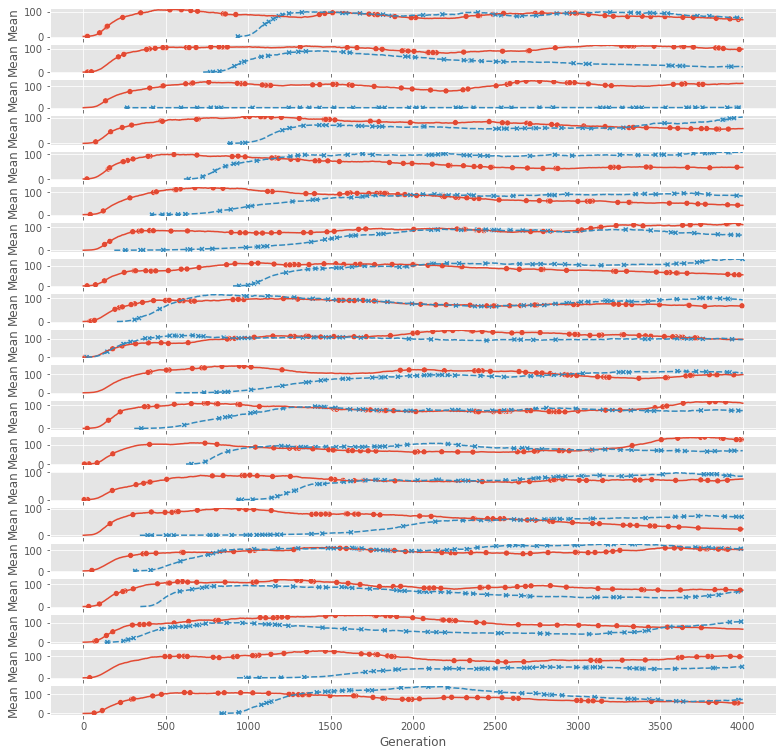

In [11]:
# Diagnostics
# Functions for mk1 eyeball sensors to detect any strange objects
def createMeanPanels(dataFrame):
    fig, axs = plt.subplots(len(dataFrame), 1, sharex=True, figsize=(13, 13))
    # f, ax = plt.subplots()
    for i in range(len(dataFrame)):
        TECNplot(pd.DataFrame(dataFrame.iloc[i]).T, axs[i], legend=False)


subsetDF = result_all.loc[np.random.choice(result_all.index, 20, replace=False)]
createMeanPanels(subsetDF)

In [ ]:
cmap = sns.color_palette("YlGfn", as_cmap=True)